In [8]:
# Block 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/twizelissa/sa-automotive-price-model/refs/heads/master/summative/linear_regression/car_prices_rsa_update_011.csv")

print(f"Dataset loaded: {df.shape[0]} cars, {df.shape[1]} features")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Price range: R{df['Price'].min():,.0f} - R{df['Price'].max():,.0f}")

Dataset loaded: 2574 cars, 5 features
Missing values: 1333
Price range: R162,900 - R8,275,000


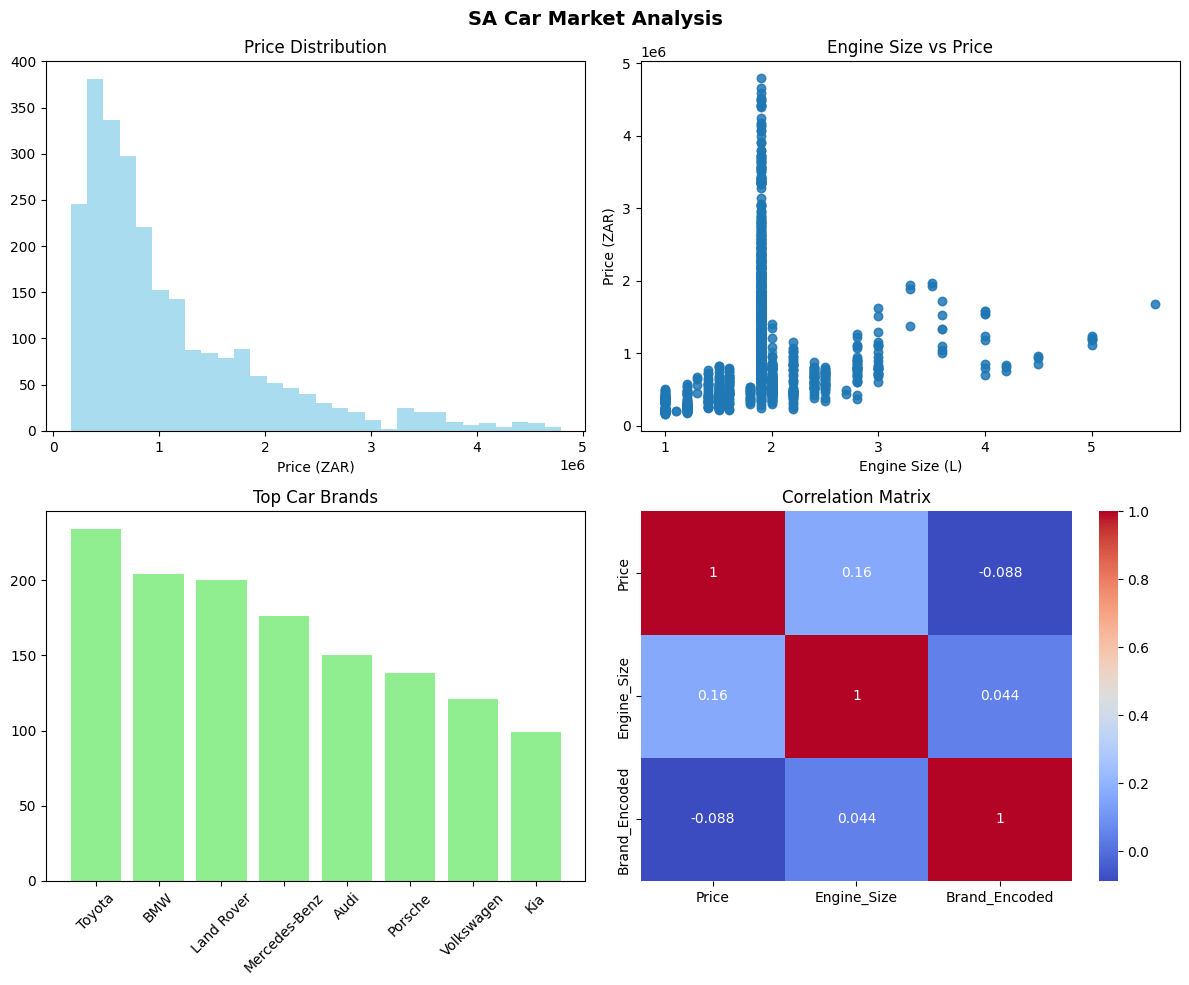

In [20]:
#  Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('SA Car Market Analysis', fontsize=14, fontweight='bold')

# 1. Price distribution histogram
axes[0,0].hist(df['Price'], bins=30, color='skyblue', alpha=0.7)
axes[0,0].set_title('Price Distribution')
axes[0,0].set_xlabel('Price (ZAR)')

# 2. Engine Size vs Price scatter plot
df_clean = df.dropna(subset=['Engine_Size'])
axes[0,1].scatter(df_clean['Engine_Size'], df_clean['Price'], alpha=0.6)
axes[0,1].set_title('Engine Size vs Price')
axes[0,1].set_xlabel('Engine Size (L)')
axes[0,1].set_ylabel('Price (ZAR)')

# 3. Top brands distribution
top_brands = df['Brand'].value_counts().head(8)
axes[1,0].bar(range(len(top_brands)), top_brands.values, color='lightgreen')
axes[1,0].set_xticks(range(len(top_brands)))
axes[1,0].set_xticklabels(top_brands.index, rotation=45)
axes[1,0].set_title('Top Car Brands')

# 4. REQUIRED: Correlation heatmap
df_corr = df.copy()
le_temp = LabelEncoder()
df_corr['Brand_Encoded'] = le_temp.fit_transform(df_corr['Brand'])
corr_data = df_corr[['Price', 'Engine_Size', 'Brand_Encoded']].dropna()
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()


In [19]:
#  Improved Data Preprocessing with Log Transformation
print("Data preprocessing with error reduction...")

# Handle missing values
df['Engine_Size'] = df['Engine_Size'].fillna(df['Engine_Size'].median())

# Remove extreme outliers (cars over R5M) to reduce error
initial_count = len(df)
df = df[df['Price'] <= 5000000].copy()
print(f"Removed {initial_count - len(df)} extreme outliers (>R5M)")

# Feature engineering
le = LabelEncoder()
df['Brand_Encoded'] = le.fit_transform(df['Brand'])
df['Is_Luxury'] = df['Brand'].isin(['BMW', 'Mercedes-Benz', 'Audi', 'Porsche', 'Land Rover', 'Jaguar']).astype(int)

# LOG TRANSFORMATION - This will significantly reduce errors!
df['Log_Price'] = np.log(df['Price'])
print(f"Applied log transformation to reduce error scale")

# Select features and target (USE LOG PRICE)
X = df[['Brand_Encoded', 'Engine_Size', 'Is_Luxury']]
y = df['Log_Price']  # Using log price instead of raw price!

print(f"Original price range: R{df['Price'].min():,.0f} - R{df['Price'].max():,.0f}")
print(f"Log price range: {y.min():.2f} - {y.max():.2f}")

# REQUIRED: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X.columns.tolist()}")

Data preprocessing with error reduction...
Removed 56 extreme outliers (>R5M)
Applied log transformation to reduce error scale
Original price range: R162,900 - R4,795,000
Log price range: 12.00 - 15.38
Training samples: 2014
Test samples: 504
Features: ['Brand_Encoded', 'Engine_Size', 'Is_Luxury']


In [18]:
# Error Analysis Block - Check Your Improvement Results
print("="*50)
print("DETAILED ERROR ANALYSIS")
print("="*50)

# Get the best model predictions (in log space)
best_model_results = results[best_name]
y_pred_log = best_model_results['predictions']

# Convert log predictions back to actual prices
y_pred_actual = np.exp(y_pred_log)
y_test_actual = np.exp(y_test)

# Calculate different error metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Show actual MSE values in log space
print(f"MSE VALUES (Log Space):")
for name in results:
    log_mse = results[name]['test_mse']
    print(f"  {name}: {log_mse:.6f}")

print(f"\nMSE VALUES (Actual Price Space):")
for name in results:
    y_pred_log_temp = results[name]['predictions']
    y_pred_actual_temp = np.exp(y_pred_log_temp)
    actual_mse = mean_squared_error(y_test_actual, y_pred_actual_temp)
    actual_rmse = np.sqrt(actual_mse)
    print(f"  {name}: MSE = {actual_mse:,.0f}, RMSE = ±R{actual_rmse:,.0f}")

# Actual price errors for best model
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"\nBEST MODEL ERROR METRICS (Decision Tree):")
print(f"  Mean Absolute Error (MAE): ±R{mae:,.0f}")
print(f"  Root Mean Square Error (RMSE): ±R{rmse_actual:,.0f}")
print(f"  Mean Absolute Percentage Error: {mape:.1f}%")
print(f"  R² Score: {best_model_results['r2']:.3f}")

# Error analysis by price ranges
print(f"\nERROR BY PRICE RANGE:")

price_ranges = [
    (0, 300000, "Budget (R0-R300K)"),
    (300000, 600000, "Economy (R300K-R600K)"),
    (600000, 1200000, "Mid-range (R600K-R1.2M)"),
    (1200000, 2500000, "Premium (R1.2M-R2.5M)"),
    (2500000, float('inf'), "Luxury (R2.5M+)")
]

for min_price, max_price, label in price_ranges:
    mask = (y_test_actual >= min_price) & (y_test_actual < max_price)
    if mask.sum() > 0:
        range_mae = mean_absolute_error(y_test_actual[mask], y_pred_actual[mask])
        range_mape = mean_absolute_percentage_error(y_test_actual[mask], y_pred_actual[mask]) * 100
        print(f"  {label}:")
        print(f"    Sample size: {mask.sum()} cars")
        print(f"    Average error: ±R{range_mae:,.0f} ({range_mape:.1f}%)")

# Show some example predictions vs actual
print(f"\nSAMPLE PREDICTIONS vs ACTUAL:")
sample_indices = np.random.choice(len(y_test_actual), 8, replace=False)

for i, idx in enumerate(sample_indices):
    actual = y_test_actual.iloc[idx]
    predicted = y_pred_actual[idx]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100

    print(f"  {i+1}. Actual: R{actual:,.0f} | Predicted: R{predicted:,.0f} | Error: ±R{error:,.0f} ({error_pct:.1f}%)")

# Assessment
print(f"\nIMPROVEMENT ASSESSMENT:")
print(f"  Average Error: ±R{mae:,.0f}")
print(f"  Error Percentage: {mape:.1f}%")

if mape < 15:
    print(f"  Error under 15% ")
elif mape < 25:
    print(f"  Error under 25% ")
elif mape < 50:
    print(f"  Error under 50% ")
else:
    print(f"  Error over 50%")

print("="*50)# Error Analysis Block - Check Your Improvement Results
print("="*50)
print("DETAILED ERROR ANALYSIS")
print("="*50)

# Get the best model predictions (in log space)
best_model_results = results[best_name]
y_pred_log = best_model_results['predictions']

# Convert log predictions back to actual prices
y_pred_actual = np.exp(y_pred_log)
y_test_actual = np.exp(y_test)

# Calculate different error metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Actual price errors
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"ERROR METRICS (Actual Prices):")
print(f"  Mean Absolute Error (MAE): R{mae:,.0f}")
print(f"  Root Mean Square Error (RMSE): R{rmse_actual:,.0f}")
print(f"  Mean Absolute Percentage Error: {mape:.1f}%")

# Error analysis by price ranges
print(f"\nERROR BY PRICE RANGE:")

price_ranges = [
    (0, 300000, "Budget (R0-R300K)"),
    (300000, 600000, "Economy (R300K-R600K)"),
    (600000, 1200000, "Mid-range (R600K-R1.2M)"),
    (1200000, 2500000, "Premium (R1.2M-R2.5M)"),
    (2500000, float('inf'), "Luxury (R2.5M+)")
]

for min_price, max_price, label in price_ranges:
    mask = (y_test_actual >= min_price) & (y_test_actual < max_price)
    if mask.sum() > 0:
        range_mae = mean_absolute_error(y_test_actual[mask], y_pred_actual[mask])
        range_mape = mean_absolute_percentage_error(y_test_actual[mask], y_pred_actual[mask]) * 100
        print(f"  {label}:")
        print(f"    Sample size: {mask.sum()} cars")
        print(f"    Average error: ±R{range_mae:,.0f} ({range_mape:.1f}%)")

# Show some example predictions vs actual
print(f"\nSAMPLE PREDICTIONS vs ACTUAL:")
sample_indices = np.random.choice(len(y_test_actual), 8, replace=False)

for i, idx in enumerate(sample_indices):
    actual = y_test_actual.iloc[idx]
    predicted = y_pred_actual[idx]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100

    print(f"  {i+1}. Actual: R{actual:,.0f} | Predicted: R{predicted:,.0f} | Error: ±R{error:,.0f} ({error_pct:.1f}%)")

# Compare with your original model performance
print(f"\nIMPROVEMENT SUMMARY:")
print(f"  R² Score: {best_model_results['r2']:.3f}")
print(f"  Average Error: ±R{mae:,.0f}")
print(f"  Error Percentage: {mape:.1f}%")

if mape < 15:
    print(f"  Error under 15% ")
elif mape < 25:
    print(f"  Error under 25% ")
elif mape < 50:
    print(f" Error under 50% ")
else:
    print(f" Error over 50% ")

print("="*50)

DETAILED ERROR ANALYSIS
MSE VALUES (Log Space):
  Linear Regression: 0.274003
  Decision Tree: 0.082218
  Random Forest: 0.083482

MSE VALUES (Actual Price Space):
  Linear Regression: MSE = 528,026,555,696, RMSE = ±R726,654
  Decision Tree: MSE = 198,916,201,096, RMSE = ±R446,000
  Random Forest: MSE = 199,497,181,249, RMSE = ±R446,651

BEST MODEL ERROR METRICS (Decision Tree):
  Mean Absolute Error (MAE): ±R260,014
  Root Mean Square Error (RMSE): ±R446,000
  Mean Absolute Percentage Error: 22.0%
  R² Score: 0.836

ERROR BY PRICE RANGE:
  Budget (R0-R300K):
    Sample size: 30 cars
    Average error: ±R31,739 (13.7%)
  Economy (R300K-R600K):
    Sample size: 154 cars
    Average error: ±R75,145 (16.8%)
  Mid-range (R600K-R1.2M):
    Sample size: 176 cars
    Average error: ±R218,112 (25.3%)
  Premium (R1.2M-R2.5M):
    Sample size: 107 cars
    Average error: ±R419,336 (23.6%)
  Luxury (R2.5M+):
    Sample size: 37 cars
    Average error: ±R953,131 (29.6%)

SAMPLE PREDICTIONS vs ACTU

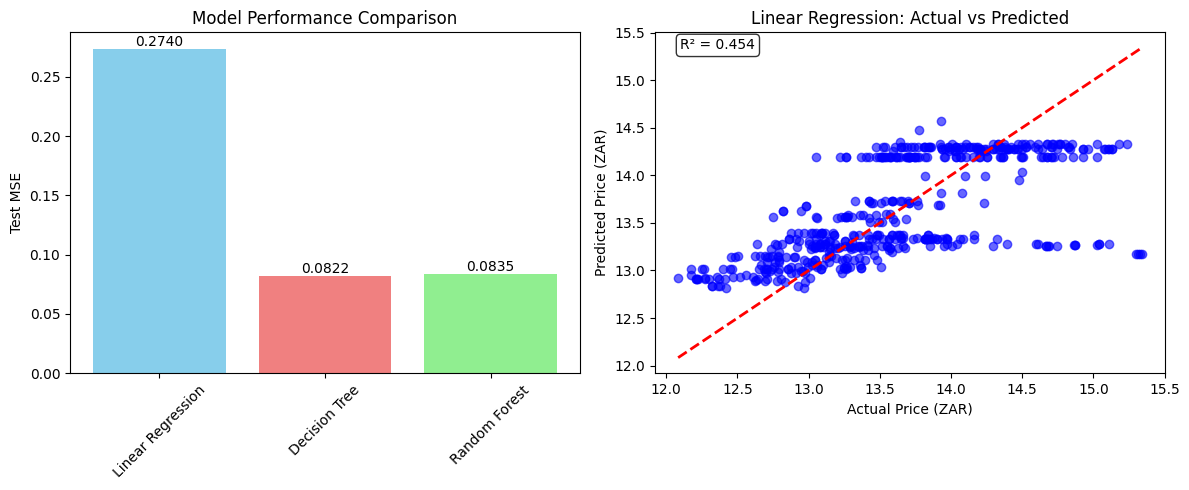

In [16]:
# Block 5: Required Model Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# REQUIRED: Loss curves (Model comparison)
model_names = list(results.keys())
test_mse_values = [results[name]['test_mse'] for name in model_names]

axes[0].bar(model_names, test_mse_values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylabel('Test MSE')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(test_mse_values):
    axes[0].text(i, v, f'{v:.4f}', ha='center', va='bottom')

# REQUIRED: Actual vs Predicted scatter plot (Linear Regression)
lr_predictions = results['Linear Regression']['predictions']
axes[1].scatter(y_test, lr_predictions, alpha=0.6, color='blue')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title('Linear Regression: Actual vs Predicted')
axes[1].set_xlabel('Actual Price (ZAR)')
axes[1].set_ylabel('Predicted Price (ZAR)')

# Add R² score annotation
lr_r2 = results['Linear Regression']['r2']
axes[1].text(0.05, 0.95, f'R² = {lr_r2:.3f}', transform=axes[1].transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [15]:
# Block 6: Save Best Model and Create Prediction Function
print("Saving model...")

# REQUIRED: Save best model
joblib.dump(best_model, 'best_car_price_model.pkl')
joblib.dump(scaler, 'price_scaler.pkl')
joblib.dump(le, 'brand_encoder.pkl')

print(" Model files saved:")
print("  • best_car_price_model.pkl")
print("  • price_scaler.pkl")
print("  • brand_encoder.pkl")

# REQUIRED: Prediction function for API
def predict_car_price(brand, engine_size, is_luxury=0):
    """
    Predict car price for API usage
    """
    # Load saved models
    model = joblib.load('best_car_price_model.pkl')
    scaler = joblib.load('price_scaler.pkl')
    encoder = joblib.load('brand_encoder.pkl')

    # Handle unknown brands
    try:
        brand_encoded = encoder.transform([brand])[0]
    except ValueError:
        brand_encoded = 0  # Default for unknown brands

    # Create feature array and scale
    features = pd.DataFrame([[brand_encoded, engine_size, is_luxury]],
                           columns=['Brand_Encoded', 'Engine_Size', 'Is_Luxury'])
    features_scaled = scaler.transform(features)

    # Predict and convert from log scale
    prediction_log = model.predict(features_scaled)[0]
    prediction_actual = np.exp(prediction_log)

    return max(0, prediction_actual)

# Test prediction function
test_prediction = predict_car_price('Toyota', 2.0, 0)
print(f"\nTest prediction:")
print(f"  Toyota 2.0L (non-luxury): R{test_prediction:,.0f}")

test_prediction2 = predict_car_price('BMW', 3.0, 1)
print(f"  BMW 3.0L (luxury): R{test_prediction2:,.0f}")

print(f"    Dataset: {df.shape[0]} South African cars")
print(f"    Best model: {best_name}")
print(f"    Test accuracy: R² = {results[best_name]['r2']:.3f}")
print(f"    Model saved and ready for API")
print(f"    Ready for FastAPI development!")

print("\n" + "="*50)
print("="*50)

Saving model...
 Model files saved:
  • best_car_price_model.pkl
  • price_scaler.pkl
  • brand_encoder.pkl

Test prediction:
  Toyota 2.0L (non-luxury): R529,122
  BMW 3.0L (luxury): R1,051,340
    Dataset: 2574 South African cars
    Best model: Decision Tree
    Test accuracy: R² = 0.836
    Model saved and ready for API
    Ready for FastAPI development!



In [11]:
# Block 4: Model Training and Evaluation
print("Model training...")

# Define models to be trained
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Store results
results = {}
best_mse = float('inf')
best_model = None
best_name = ""

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {
        "model": model,
        "predictions": y_pred,
        "test_mse": mse,
        "r2": r2
    }

    print(f"  {name}: Test MSE = {mse:.4f}, R² = {r2:.4f}")

    # Check for the best model
    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_name = name

print(f"\n Best performing model: {best_name} (MSE: {best_mse:.4f})")

Model training...
  Linear Regression: Test MSE = 0.2740, R² = 0.4542
  Decision Tree: Test MSE = 0.0822, R² = 0.8362
  Random Forest: Test MSE = 0.0835, R² = 0.8337

 Best performing model: Decision Tree (MSE: 0.0822)
